In [284]:
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import seaborn as sb
import matplotlib.pyplot as plt


Load the dataset

In [285]:
df = pd.read_csv("all_ticks_long.csv")

Display the unique values in the 'short_name' column to check different stock names

In [286]:
df["short_name"].unique()

array(['AEFES', 'AKBNK', 'AKSA', 'AKSEN', 'ALARK', 'ALBRK', 'ANACM',
       'ARCLK', 'ASELS', 'ASUZU', 'AYGAZ', 'BAGFS', 'BANVT', 'BRISA',
       'CCOLA', 'CEMAS', 'ECILC', 'EREGL', 'FROTO', 'GARAN', 'GOODY',
       'GUBRF', 'HALKB', 'ICBCT', 'ISCTR', 'ISDMR', 'ISFIN', 'ISYAT',
       'KAREL', 'KARSN', 'KCHOL', 'KRDMB', 'KRDMD', 'MGROS', 'OTKAR',
       'PARSN', 'PETKM', 'PGSUS', 'PRKME', 'SAHOL', 'SASA', 'SISE',
       'SKBNK', 'SODA', 'TCELL', 'THYAO', 'TKFEN', 'TOASO', 'TRKCM',
       'TSKB', 'TTKOM', 'TUKAS', 'TUPRS', 'USAK', 'VAKBN', 'VESTL',
       'YATAS', 'YKBNK', 'YUNSA', 'ZOREN'], dtype=object)

Select a specific stock to analyze

In [287]:
stock="TCELL"

In [288]:
stock_df=df[df["short_name"] ==stock]

In [289]:
stock_df.head()

,short_name,timestamp,price
2075043,TCELL,2012-09-17T06:45:00Z,4.5359
2075044,TCELL,2012-09-17T07:00:00Z,4.5153
2075045,TCELL,2012-09-17T07:15:00Z,4.5153
2075046,TCELL,2012-09-17T07:30:00Z,4.5359
2075047,TCELL,2012-09-17T07:45:00Z,4.5153


Convert the 'timestamp' column to datetime and localize it to 'Europe/Istanbul' time

In [290]:
stock_df['timestamp'] = pd.to_datetime(stock_df['timestamp'])
stock_df['timestamp']  = stock_df['timestamp'].dt.tz_convert('Europe/Istanbul')

C:\Users\Monster\AppData\Local\Temp\ipykernel_6616\279024071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['timestamp'] = pd.to_datetime(stock_df['timestamp'])
C:\Users\Monster\AppData\Local\Temp\ipykernel_6616\279024071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['timestamp']  = stock_df['timestamp'].dt.tz_convert('Europe/Istanbul')


Remove the timezone information to avoid confusion

In [291]:

stock_df = stock_df.set_index(stock_df['timestamp'])
stock_df.index = stock_df.index.tz_localize(None)

Define date limits for the analysis

In [292]:
lwr_limit_date = "2017-01-01" 
middle_limit_date = "2018-01-01"
uppr_limit_date ="2019-01-01"

Filter the dataframe based on the date limits

In [293]:
stock_df = stock_df[stock_df.index > lwr_limit_date ]
stock_df = stock_df[stock_df.index < uppr_limit_date]

Resample the data to daily frequency, taking the last price each day

In [294]:
day_stock_df=stock_df["price"].groupby(pd.Grouper(freq="1440min")).last().rename("Close").to_frame()

Drop NA

In [295]:
day_stock_df.dropna(inplace=True)
day_stock_df = day_stock_df[day_stock_df.index.weekday < 5]

#### Feature Engineering

In [296]:
day_stock_df["LagClose"]=day_stock_df["Close"].shift(1) # Create a lagged version of the close price for further analysis
day_stock_df["Var"]=stock_df["price"].groupby(pd.Grouper(freq="1440min")).var() # Calculate the variance of the price for each day
day_stock_df["NormVar"]=(day_stock_df['Var'] - day_stock_df['Var'].min()) / (day_stock_df['Var'].max() - day_stock_df['Var'].min()) # Normalize the variance to have it on a scale from 0 to 1

In [297]:
day_stock_df.head()

,Close,LagClose,Var,NormVar
timestamp,,,,
2017-01-02,8.0025,NaN,0.000450,0.003060
2017-01-03,7.8353,8.0025,0.001250,0.010888
2017-01-04,8.0109,7.8353,0.001702,0.015311
2017-01-05,8.0946,8.0109,0.002097,0.019182
2017-01-06,8.2534,8.0946,0.002058,0.018802


In [298]:
day_stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 2017-01-02 to 2018-12-31
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     504 non-null    float64
 1   LagClose  503 non-null    float64
 2   Var       504 non-null    float64
 3   NormVar   504 non-null    float64
dtypes: float64(4)
memory usage: 19.7 KB


In [299]:
day_stock_df.dropna(inplace=True)

In [300]:
day_stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2017-01-03 to 2018-12-31
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     503 non-null    float64
 1   LagClose  503 non-null    float64
 2   Var       503 non-null    float64
 3   NormVar   503 non-null    float64
dtypes: float64(4)
memory usage: 19.6 KB


Calculate the percentage change in price from the previous day

In [301]:
day_stock_df["PercentChange"]=(day_stock_df["Close"]-day_stock_df["LagClose"])/day_stock_df["LagClose"]*100

Extract Month and Year from the index for grouping purposes

In [302]:
day_stock_df["Date"]=day_stock_df.index
day_stock_df["Month"]=day_stock_df["Date"].apply(lambda x: x.month)
day_stock_df["Year"]=day_stock_df["Date"].apply(lambda x: x.year)
day_stock_df.drop(columns=["Date"],inplace=True)

Display data for a specific date range

In [303]:
day_stock_df.loc["2018-09-10":"2018-09-20"]

,Close,LagClose,Var,NormVar,PercentChange,Month,Year
timestamp,,,,,,,
2018-09-10,10.2578,10.2578,0.003854,0.036385,0.000000,9,2018
2018-09-11,10.1151,10.2578,0.004317,0.040916,-1.391137,9,2018
2018-09-12,9.9058,10.1151,0.008350,0.080402,-2.069184,9,2018
2018-09-13,10.7337,9.9058,0.068359,0.667887,8.357730,9,2018
2018-09-14,10.6575,10.7337,0.014639,0.141972,-0.709914,9,2018
2018-09-17,10.9094,10.6575,0.010015,0.096705,2.363594,9,2018
2018-09-18,10.9582,10.9094,0.001586,0.014178,0.447321,9,2018
2018-09-19,10.8605,10.9582,0.011680,0.112998,-0.891570,9,2018
2018-09-20,11.1340,10.8605,0.003561,0.033513,2.518300,9,2018


 Plot a scatter plot of percentage change over time

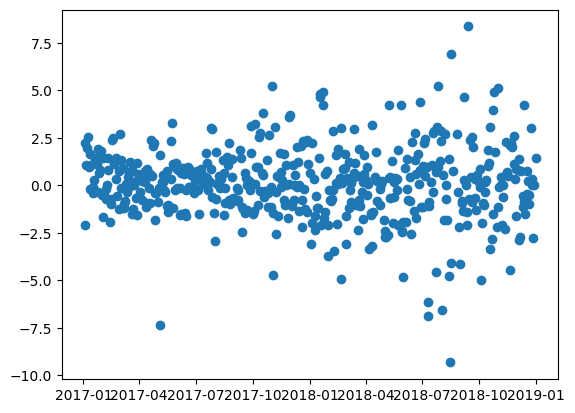

In [304]:
plt.scatter(day_stock_df.index,day_stock_df["PercentChange"])

Split the data into two different dataframes based on the defined limit date

In [305]:
first_year=day_stock_df[day_stock_df.index<middle_limit_date]
second_year=day_stock_df[day_stock_df.index>middle_limit_date]

Create a boxplot of the percentage change for each month of the first year

<Axes: xlabel='timestamp', ylabel='PercentChange'>

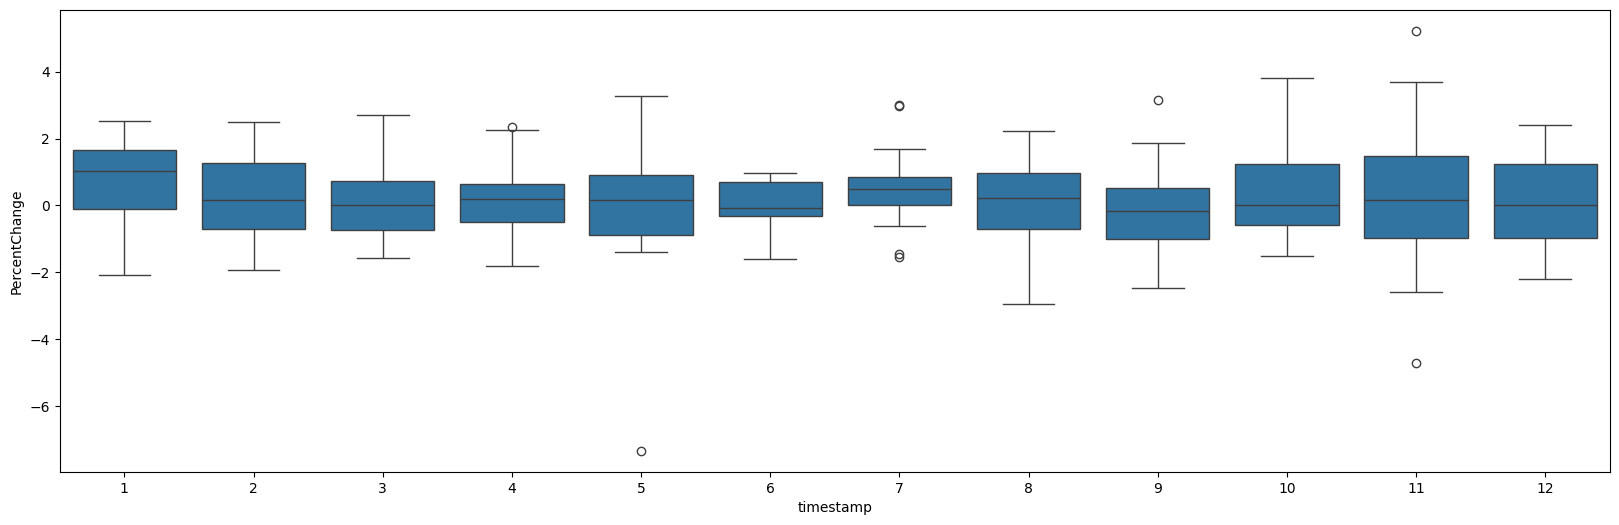

In [306]:
plt.figure(figsize=(20, 6))
sb.boxplot(y=first_year["PercentChange"],x=first_year.index.month)

Create a boxplot of the percentage change for each month of the second year

<Axes: xlabel='timestamp', ylabel='PercentChange'>

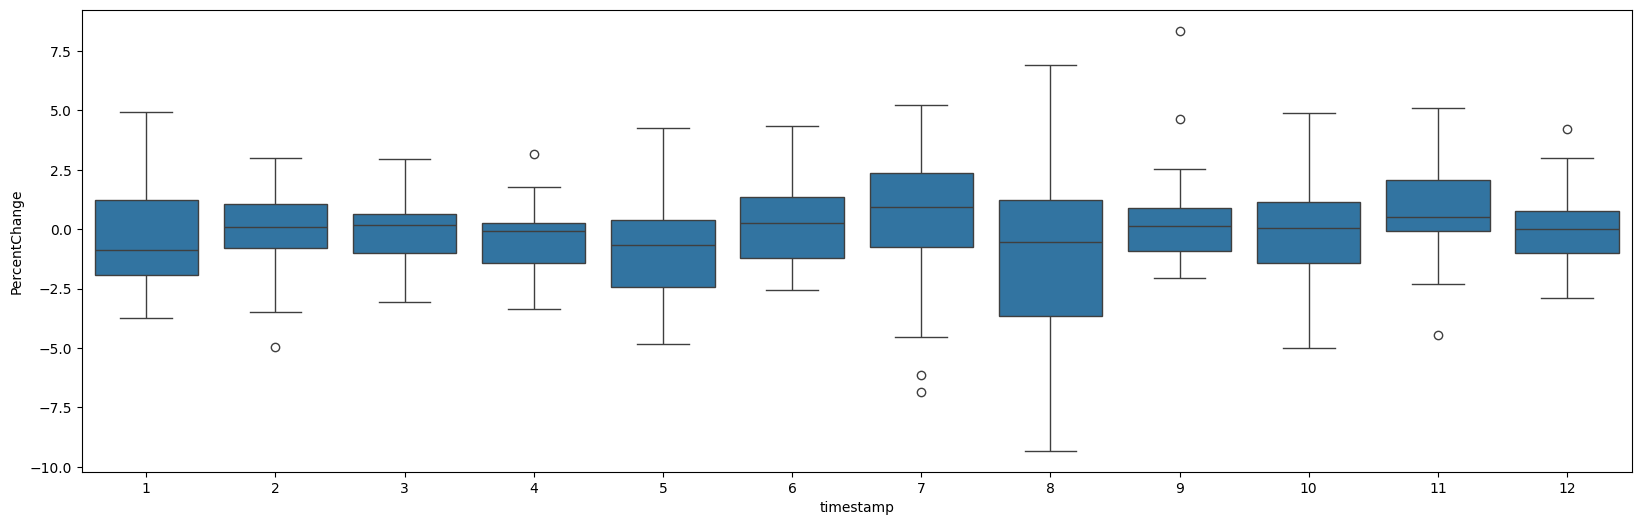

In [307]:
plt.figure(figsize=(20, 6))
sb.boxplot(y=second_year["PercentChange"],x=second_year.index.month)

Define a function to find outliers in a dataset based on the IQR method

In [308]:
def find_outliers(df,column="PercentChange"):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

Loop through each year and month to find outliers

In [309]:
flag=0
for year in day_stock_df["Year"].unique():
    df_year=day_stock_df[day_stock_df["Year"]== year]
    for month in day_stock_df["Month"].unique():
        df=df_year[df_year["Month"]==month]
        if flag==0:
            OC_outliers=find_outliers(df)
            flag=1
        else:
            monthly_outliers=find_outliers(df)
            OC_outliers=pd.concat([OC_outliers,monthly_outliers])

 Similar loop to find outliers within a 15-day period before and after each month

In [310]:
flag=0
for year in day_stock_df["Year"].unique():
    df_year=day_stock_df[day_stock_df["Year"]== year]
    for month in day_stock_df["Month"].unique():
        if month==1:
            start_date = str(year-1)+"-"+str(12)+"-15"
            end_date = str(year)+"-"+str(month)+"-15"
        else:
            start_date = str(year)+"-"+str(month-1)+"-15"
            end_date = str(year)+"-"+str(month)+"-15"
        df=df_year.loc[start_date:end_date]
        if flag==0:
            OC_outliers15=find_outliers(df)
            flag=1
        else:
            monthly_outliers=find_outliers(df)
            OC_outliers15=pd.concat([OC_outliers15,monthly_outliers])

 Find the common indices between the two outlier dataframes

In [311]:
common_indexs = OC_outliers.index.intersection(OC_outliers15.index)

Get the outliers that are common in both periods

In [312]:
outliers=OC_outliers.loc[common_indexs]

Display the common outliers

In [313]:
outliers

,Close,LagClose,Var,NormVar,PercentChange,Month,Year
timestamp,,,,,,,
2017-04-20,10.1600,9.9259,0.004446,0.042182,2.358476,4,2017
2017-05-04,9.5162,10.2687,0.001431,0.012664,-7.328094,5,2017
2017-07-07,10.0893,10.2457,0.001078,0.009207,-1.526494,7,2017
2017-11-01,13.4303,12.7637,0.040955,0.399601,5.222624,11,2017
2017-11-02,12.7997,13.4303,0.102282,1.000000,-4.695353,11,2017
2018-02-20,13.5576,14.2629,0.041883,0.408686,-4.944997,2,2018
2018-07-10,11.5234,12.2751,0.046620,0.455062,-6.123779,7,2018
2018-07-11,10.7337,11.5234,0.031914,0.311088,-6.853012,7,2018
2018-09-07,10.2578,9.8012,0.015909,0.154403,4.658613,9,2018


 Save the common outliers to a CSV file in the specified directory

In [314]:
outliers.to_csv("outliers/"+stock+"_outliers.csv")